# B-Splines Benchmarks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Robert-Schmid/uf3/blob/jax/examples/jax-md/benchmarks/B-Spline-Benchmark.ipynb)

In [ ]:
@title install UF3
!git clone -b jax https://github.com/Robert-Schmid/uf3.git
%cd /content/uf3
!pip install -r requirements.txt
!pip install -e .
%cd /content/uf3/examples/jax-md

!pip install -q git+https://www.github.com/google/jax-md

In [1]:
from uf3.jax.jax_splines import *
from uf3.util.random import random_spline

import jax.numpy as jnp
from jax import jit, grad, vmap, value_and_grad
import jax

import numpy as onp

import ndsplines
from scipy.interpolate import BSpline

import time
import timeit

import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)

import string

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Benchmarks for Splines

## The fastest backend for cubic splines
- (1D and 3D)
- CPU vs GPU

### 1D

In [2]:
seed = 123
dimension = 1
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'Symbolic': (BSplineBackend.Symbolic, 'cpu'),
    'deBoor' : (BSplineBackend.DeBoor, 'cpu'),
    'Symbolic-gpu' : (BSplineBackend.Symbolic, 'gpu'),
    'deBoor-gpu' : (BSplineBackend.DeBoor, 'gpu')
}

for key in settings.keys():
    timings[key] = None
    backend, device = settings[key]

    for exponent in range(2,8):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)
        s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

        x_jax = jax.device_put(x)

        fn = jit(vmap(s), backend=device)

        sym = lambda : fn(*x_jax).block_until_ready()

        try:
            t = timeit.Timer(sym).repeat(repeat=6, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        print(f"{key}: 10e{exponent} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break

timings1 = timings

Symbolic: 10e2 - [1.00000000e+02 3.14949553e-01 9.94708389e-05 5.02914190e-05
 4.17511910e-05 3.94694507e-05 3.73758376e-05]
Symbolic: 10e3 - [1.00000000e+03 2.70170555e-01 1.12270936e-04 7.37272203e-05
 6.63995743e-05 6.23390079e-05 6.13518059e-05]
Symbolic: 10e4 - [1.00000000e+04 2.48339526e-01 4.57603484e-04 4.05315310e-04
 3.96071002e-04 3.88350338e-04 3.91731039e-04]
Symbolic: 10e5 - [1.00000000e+05 3.20545696e-01 2.53014453e-03 2.26325355e-03
 2.20407546e-03 2.21044756e-03 2.18342803e-03]
Symbolic: 10e6 - [1.00000000e+06 3.45662447e-01 4.24293522e-02 4.19394597e-02
 4.19858918e-02 4.20066006e-02 4.18404751e-02]
Symbolic: 10e7 - [1.00000000e+07 7.75200861e-01 4.83557075e-01 4.77156945e-01
 4.80058834e-01 4.77106180e-01 4.76602079e-01]
deBoor: 10e2 - [1.00000000e+02 2.27566956e-01 7.89482147e-05 4.94159758e-05
 4.43439931e-05 3.33469361e-05 3.09217721e-05]
deBoor: 10e3 - [1.00000000e+03 2.46047147e-01 1.41622499e-04 8.23996961e-05
 7.19539821e-05 6.76605850e-05 6.35143369e-05]
deBo

In [3]:
seed = 123
dimension = 1
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'Symbolic': (BSplineBackend.Symbolic, 'cpu'),
    'deBoor' : (BSplineBackend.DeBoor, 'cpu'),
    'Symbolic-gpu' : (BSplineBackend.Symbolic, 'gpu'),
    'deBoor-gpu' : (BSplineBackend.DeBoor, 'gpu')
}

for key in settings.keys():
    timings[key] = None
    backend, device = settings[key]

    for exponent in range(2,8):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)
        s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

        x_jax = jax.device_put(x)

        fn = jit(vmap(grad(s)), backend=device)

        sym = lambda : fn(*x_jax).block_until_ready()

        try:
            t = timeit.Timer(sym).repeat(repeat=6, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        print(f"{key}: 10e{exponent} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break

timings1der = timings

Symbolic: 10e2 - [1.00000000e+02 3.68040800e-01 9.49501991e-05 5.26998192e-05
 3.51946801e-05 3.20076942e-05 3.11117619e-05]
Symbolic: 10e3 - [1.00000000e+03 4.10352079e-01 1.80305913e-04 8.86023045e-05
 9.48980451e-05 8.14516097e-05 7.91568309e-05]
Symbolic: 10e4 - [1.00000000e+04 3.78652435e-01 4.12490219e-04 2.96145678e-04
 2.82201916e-04 2.91980803e-04 3.04987654e-04]
Symbolic: 10e5 - [1.00000000e+05 4.19069160e-01 2.78693251e-03 2.53369845e-03
 1.96159445e-03 2.72925943e-03 2.24089622e-03]
Symbolic: 10e6 - [1.00000000e+06 4.66252308e-01 3.75744682e-02 4.63801920e-02
 4.77770604e-02 3.67586482e-02 4.77347281e-02]
Symbolic: 10e7 - [1.00000000e+07 8.49800261e-01 4.25803371e-01 4.23393084e-01
 4.48754868e-01 4.42227086e-01 4.52859236e-01]
deBoor: 10e2 - [1.00000000e+02 3.00044704e-01 1.36191025e-04 4.60054725e-05
 3.56007367e-05 3.22274864e-05 3.06610018e-05]
deBoor: 10e3 - [1.00000000e+03 3.16063389e-01 1.13816932e-04 7.82664865e-05
 6.43953681e-05 6.02435321e-05 5.73303550e-05]
deBo

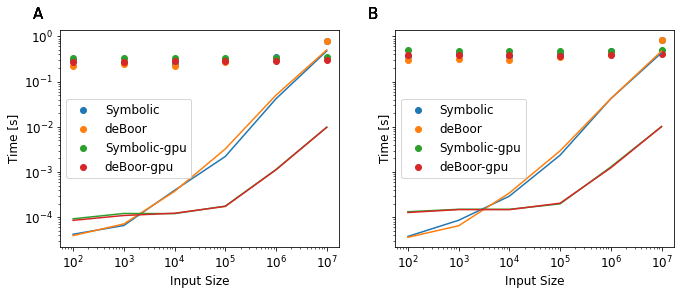

In [4]:
keys = [['Symbolic','deBoor','Symbolic-gpu','deBoor-gpu'],['Symbolic','deBoor','Symbolic-gpu','deBoor-gpu']]
times = [timings1,timings1der]

fig, axs = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = times[i][k]
        x = data[:,0]
        y_jit = data[:,1]
        # y = onp.mean(data[:,2:], 1)
        y = onp.mean(onp.sort(data[:,2:],1)[:,:-1], 1)

        ax.plot(x, y)
        ax.set_xscale('log')
        ax.set_xlabel("Input Size")
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.set_ylabel("Time [s]")
        ax.legend()
        ax.text(-0.1, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=15)


plt.show()
fig.tight_layout()

# fig.savefig('1D-splines-benchmark.png', dpi=fig.dpi)

### 3D

In [8]:
seed = 123
dimension = 3
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'Symbolic': (BSplineBackend.Symbolic, 'cpu'),
    'deBoor' : (BSplineBackend.DeBoor, 'cpu'),
    'Symbolic-gpu' : (BSplineBackend.Symbolic, 'gpu'),
    'deBoor-gpu' : (BSplineBackend.DeBoor, 'gpu')
}

for key in settings.keys():
    timings[key] = None
    backend, device = settings[key]

    for exponent in range(2,8):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)
        s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

        x_jax = jax.device_put(x)

        fn = jit(vmap(s), backend=device)

        sym = lambda : fn(*x_jax).block_until_ready()

        try:
            t = timeit.Timer(sym).repeat(repeat=6, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        print(f"{key}: 10e{exponent} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break

timings2 = timings

Symbolic: 10e2 - [1.00000000e+02 8.08150044e-01 1.84232369e-04 1.00694597e-04
 9.31173563e-05 9.76752490e-05 8.75759870e-05]
Symbolic: 10e3 - [1.00000000e+03 9.15801592e-01 4.16727737e-04 3.46563756e-04
 3.28917056e-04 3.29218805e-04 3.25338915e-04]
Symbolic: 10e4 - [1.00000000e+04 8.51139072e-01 2.27443315e-03 2.08941661e-03
 2.01032497e-03 1.99573673e-03 2.00931542e-03]
Symbolic: 10e5 - [1.00000000e+05 9.83791582e-01 4.03346177e-02 3.99317034e-02
 3.64846326e-02 3.32521796e-02 3.40386219e-02]
Symbolic: 10e6 - [1.00000000e+06 1.26357955e+00 3.51032371e-01 3.41110367e-01
 3.42398232e-01 3.39656768e-01 3.40400651e-01]
Symbolic: 10e7 - [1.00000000e+07 4.38677884e+00 3.46208520e+00 3.46874610e+00
 3.48575300e+00 3.45396128e+00 3.46380510e+00]
deBoor: 10e2 - [1.00000000e+02 7.35760843e-01 2.88335606e-04 1.26773492e-04
 1.08674169e-04 1.04529783e-04 1.01499259e-04]
deBoor: 10e3 - [1.00000000e+03 8.06456652e-01 5.07285818e-04 4.21836972e-04
 4.00517136e-04 3.99867073e-04 3.93237919e-04]
deBo

In [9]:
seed = 123
dimension = 3
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'Symbolic': (BSplineBackend.Symbolic, 'cpu'),
    'deBoor' : (BSplineBackend.DeBoor, 'cpu'),
    'Symbolic-gpu' : (BSplineBackend.Symbolic, 'gpu'),
    'deBoor-gpu' : (BSplineBackend.DeBoor, 'gpu')
}

for key in settings.keys():
    timings[key] = None
    backend, device = settings[key]

    for exponent in range(2,8):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)
        s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

        x_jax = jax.device_put(x)

        fn = jit(vmap(grad(s)), backend=device)

        sym = lambda : fn(*x_jax).block_until_ready()

        try:
            t = timeit.Timer(sym).repeat(repeat=6, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        print(f"{key}: 10e{exponent} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break

timings2der = timings

Symbolic: 10e2 - [1.00000000e+02 7.85411635e-01 1.67327002e-04 1.00500882e-04
 8.37799162e-05 8.11088830e-05 7.74152577e-05]
Symbolic: 10e3 - [1.00000000e+03 8.53780592e-01 3.44427302e-04 3.04896384e-04
 2.40463763e-04 2.22919509e-04 2.25782394e-04]
Symbolic: 10e4 - [1.00000000e+04 8.02735690e-01 1.75770558e-03 1.67881139e-03
 1.62493065e-03 1.61615945e-03 1.64580345e-03]
Symbolic: 10e5 - [1.00000000e+05 9.18874208e-01 2.90362574e-02 2.87592039e-02
 2.87948437e-02 2.89616250e-02 2.87369955e-02]
Symbolic: 10e6 - [1.00000000e+06 1.18451118e+00 2.92103086e-01 2.84901429e-01
 2.83516273e-01 2.82231955e-01 2.83483433e-01]
Symbolic: 10e7 - [1.00000000e+07 3.96174614e+00 3.07204787e+00 3.03087618e+00
 3.03441342e+00 3.03008956e+00 3.03696239e+00]
deBoor: 10e2 - [1.00000000e+02 1.18462544e+00 4.00582328e-04 1.33322552e-04
 1.20496377e-04 1.12673268e-04 1.09264627e-04]
deBoor: 10e3 - [1.00000000e+03 1.27333006e+00 7.20037147e-04 6.49193302e-04
 6.40511513e-04 6.31459057e-04 6.34724274e-04]
deBo

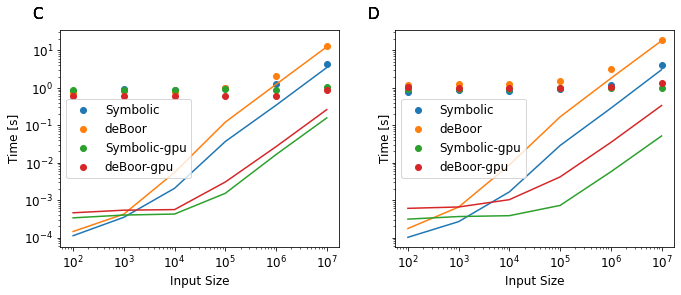

In [10]:
keys = [['Symbolic','deBoor','Symbolic-gpu','deBoor-gpu'],['Symbolic','deBoor','Symbolic-gpu','deBoor-gpu']]
times = [timings2,timings2der]


fig, axs = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = times[i][k]
        x = data[:,0]
        y_jit = data[:,1]
        y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        ax.set_xscale('log')
        ax.set_xlabel("Input Size")
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.set_ylabel("Time [s]")
        ax.legend()
        ax.text(-0.1, 1.05, string.ascii_uppercase[i+2], transform=ax.transAxes, 
            size=15)


plt.show()
fig.tight_layout()

fig.savefig('3D-splines-benchmark.png', dpi=fig.dpi)

## Comparing to other implementations (1D cubic)

- JAX
- ndspline
- scipy

In [11]:
seed = 123
dimension = 1
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.Symbolic, 'cpu'),
    'JAX-gpu' : ('jax', BSplineBackend.Symbolic, 'gpu'),
    'ND-Splines' : ('ndspline',None,None),
    'SciPy' : ('scipy',None,None)
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    for exponent in range(2,8):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(*x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs)
            sym = fn
        elif name == 'scipy':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            # s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            s = BSpline(knots[0], onp.asarray(c).copy(), ds[0])
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=6, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        print(f"{key}: 10e{exponent} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break

timings3 = timings

JAX: 10e2 - [1.00000000e+02 2.47676821e-01 8.27424228e-05 4.38373536e-05
 4.84324992e-05 3.39243561e-05 3.04598361e-05]
JAX: 10e3 - [1.00000000e+03 2.64935158e-01 1.18032098e-04 8.57003033e-05
 7.19446689e-05 6.49429858e-05 6.27674162e-05]
JAX: 10e4 - [1.00000000e+04 2.50362508e-01 4.65974212e-04 4.04592603e-04
 3.94493341e-04 3.91975045e-04 3.85154039e-04]
JAX: 10e5 - [1.00000000e+05 2.88491104e-01 2.50872970e-03 2.28693895e-03
 2.28427537e-03 2.28108279e-03 2.27899291e-03]
JAX: 10e6 - [1.00000000e+06 3.30975883e-01 4.27171737e-02 4.21220642e-02
 4.22387440e-02 4.21850700e-02 4.24706899e-02]
JAX: 10e7 - [1.00000000e+07 7.67702116e-01 4.78203673e-01 4.74525625e-01
 4.76169242e-01 4.75091347e-01 4.77654690e-01]
JAX-gpu: 10e2 - [1.00000000e+02 2.45983904e-01 1.73451379e-04 9.55443829e-05
 8.63056630e-05 8.08332115e-05 7.95107335e-05]
JAX-gpu: 10e3 - [1.00000000e+03 2.33206280e-01 1.71246007e-04 9.78745520e-05
 8.64677131e-05 8.06711614e-05 8.54972750e-05]
JAX-gpu: 10e4 - [1.00000000e+04 

In [12]:
seed = 123
dimension = 1
resolution = 20
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.Symbolic, 'cpu'),
    'JAX-gpu' : ('jax', BSplineBackend.Symbolic, 'gpu'),
    'ND-Splines' : ('ndspline',None,None),
    'SciPy' : ('scipy',None,None)
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    for exponent in range(2,8):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

            x_jax = jax.device_put(x)

            fn = jit(vmap(grad(s)), backend=device)

            sym = lambda : fn(*x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs,1)
            sym = fn
        elif name == 'scipy':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            # s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            s = BSpline(knots[0], onp.asarray(c).copy(), ds[0])
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs,1)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=6, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([size] + t)
        
        print(f"{key}: 10e{exponent} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break

timings3der = timings

JAX: 10e2 - [1.00000000e+02 3.64029625e-01 9.21469182e-05 4.65493649e-05
 3.91453505e-05 3.74633819e-05 3.31923366e-05]
JAX: 10e3 - [1.00000000e+03 3.85644238e-01 1.32404268e-04 8.47633928e-05
 7.80392438e-05 7.31088221e-05 7.09481537e-05]
JAX: 10e4 - [1.00000000e+04 3.70207405e-01 4.17454168e-04 3.07155773e-04
 2.94445083e-04 2.93850899e-04 2.89112329e-04]
JAX: 10e5 - [1.00000000e+05 4.12784167e-01 2.90708803e-03 2.55013444e-03
 2.49619782e-03 2.48049945e-03 2.37340666e-03]
JAX: 10e6 - [1.00000000e+06 4.55623319e-01 4.64682803e-02 4.70924918e-02
 3.68989110e-02 3.72730326e-02 4.83377781e-02]
JAX: 10e7 - [1.00000000e+07 8.99234068e-01 4.46169678e-01 4.39620283e-01
 4.45552513e-01 4.24818186e-01 4.44753671e-01]
JAX-gpu: 10e2 - [1.00000000e+02 3.48741116e-01 1.79916620e-04 1.26861036e-04
 1.12699345e-04 1.22046098e-04 1.15053728e-04]
JAX-gpu: 10e3 - [1.00000000e+03 3.45525963e-01 1.80723146e-04 1.30698085e-04
 1.27615407e-04 1.28975138e-04 1.21578574e-04]
JAX-gpu: 10e4 - [1.00000000e+04 

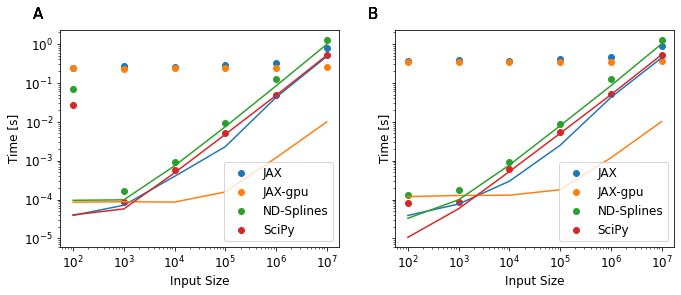

In [13]:
keys = [['JAX','JAX-gpu','ND-Splines','SciPy'],['JAX','JAX-gpu','ND-Splines','SciPy']]
times = [timings3,timings3der]

fig, axs = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = times[i][k]
        x = data[:,0]
        y_jit = data[:,1]
        # y = onp.mean(data[:,2:], 1)
        y = onp.mean(onp.sort(data[:,2:],1)[:,:-1], 1)

        ax.plot(x, y)
        ax.set_xscale('log')
        ax.set_xlabel("Input Size")
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.set_ylabel("Time [s]")
        ax.legend()
        ax.text(-0.1, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=15)

plt.show()
fig.tight_layout()
fig.savefig('scipy-benchmark.png', dpi=fig.dpi)

## Effects of higher degrees (deBoor backend and ndspline)

In [14]:
seed = 123
dimension = 1
resolution = 40
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.DeBoor, 'cpu'),
    'JAX-gpu' : ('jax', BSplineBackend.DeBoor, 'gpu'),
    'ND-Splines' : ('ndspline',None,None),
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    exponent = 6
    for degree in range(3,10):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(k, ds, c, backend=backend)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(*x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([degree] + t)
        
        print(f"{key}: {degree} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break
            
timings4 = timings

JAX: 3 - [3.         0.79206149 0.42761142 0.42116212 0.41623757]
JAX: 4 - [4.         0.967245   0.61686111 0.61695542 0.61329919]
JAX: 5 - [5.         1.3436174  0.95942633 0.93394317 0.93340908]
JAX: 6 - [6.         1.66973604 1.3255713  1.32453457 1.32538923]
JAX: 7 - [7.         2.1586871  1.82263459 1.78730347 1.78768233]
JAX: 8 - [8.         2.47494584 2.09817963 2.14316508 2.1162831 ]
JAX: 9 - [9.         3.09635    2.71419259 2.71424351 2.71845693]
JAX-gpu: 3 - [3.         0.28480569 0.01006075 0.0100232  0.01008098]
JAX-gpu: 4 - [4.         0.28230695 0.01127161 0.0113658  0.01136255]
JAX-gpu: 5 - [5.         0.29424039 0.02142288 0.02138784 0.02132404]
JAX-gpu: 6 - [6.         0.30937492 0.02812196 0.02803842 0.02817529]
JAX-gpu: 7 - [7.         0.30665351 0.03267293 0.03214872 0.03550035]
JAX-gpu: 8 - [8.         0.3051193  0.03008781 0.03013081 0.03011413]
JAX-gpu: 9 - [9.         0.32395231 0.05490134 0.05488498 0.05477104]
ND-Splines: 3 - [3.         0.13478027 0.0903224

In [ ]:
keys = [['JAX','JAX-gpu','ND-Splines']]

fig, axs = plt.subplots(1,2, figsize=(11,4), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = timings4[k]
        x = data[:,0]
        y_jit = data[:,1]
        y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        # ax.set_xscale('log')
        ax.set_xlabel("Basis Spline Degree")
        ax.scatter(x, y_jit, label=k)
        ax.set_yscale('log')
        ax.set_ylabel("Time [s]")
        ax.legend()
        ax.text(-0.1, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=15)

plt.show()


## Effects of higher dimensions

In [15]:
seed = 123
dimension = 1
resolution = 7
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.Symbolic, 'cpu'),
    'JAX-gpu' : ('jax', BSplineBackend.Symbolic, 'gpu'),
    'ND-Splines' : ('ndspline',None,None),
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    exponent = 4
    for dimension in range(1,8):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(*x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=6, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([dimension] + t)
        
        print(f"{key}: {dimension} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break
            
timings5 = timings

JAX: 1 - [1.00000000e+00 2.47134732e-01 4.50788066e-04 3.92055139e-04
 3.79990786e-04 3.72875482e-04 3.79428267e-04]
JAX: 2 - [2.00000000e+00 4.52119987e-01 9.17674974e-04 8.88317823e-04
 8.87831673e-04 8.71038064e-04 8.75886530e-04]
JAX: 3 - [3.00000000e+00 7.85400594e-01 2.13406049e-03 1.99616514e-03
 2.03767978e-03 2.05075555e-03 1.92810409e-03]
JAX: 4 - [4.         1.00403572 0.00502262 0.00477767 0.00474733 0.00478028
 0.00480099]
JAX: 5 - [5.         1.32779696 0.03510221 0.03477964 0.03469139 0.03474093
 0.03458474]
JAX: 6 - [6.         1.95107144 0.12779462 0.12803752 0.12817574 0.12844771
 0.12821734]
JAX: 7 - [7.         5.32155879 0.50632961 0.50989943 0.50713103 0.50852008
 0.50795462]
JAX-gpu: 1 - [1.00000000e+00 3.29763627e-01 1.99941359e-03 1.40992925e-04
 8.85650516e-05 8.89170915e-05 1.29517168e-04]
JAX-gpu: 2 - [2.00000000e+00 5.87694919e-01 3.25441360e-04 2.39165500e-04
 2.18937173e-04 2.13719904e-04 2.10057944e-04]
JAX-gpu: 3 - [3.00000000e+00 8.34498340e-01 5.11059

In [16]:
seed = 123
dimension = 1
resolution = 15
degree = 3
max_time = 1
repeats=4

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.Symbolic, 'cpu'),
    'JAX-gpu' : ('jax', BSplineBackend.Symbolic, 'gpu'),
    'ND-Splines' : ('ndspline',None,None),
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    exponent = 4
    for dimension in range(1,7):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(k, ds, c,backend=backend, compress=True)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(*x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([dimension] + t)
        
        print(f"{key}: {dimension} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break
            
timings8 = timings

JAX: 1 - [1.00000000e+00 2.67699011e-01 4.98408452e-04 4.11605462e-04
 4.00060788e-04]
JAX: 2 - [2.00000000e+00 4.71067034e-01 9.96915624e-04 9.52795148e-04
 9.46419314e-04]
JAX: 3 - [3.00000000e+00 7.91801788e-01 2.14323215e-03 2.02023983e-03
 1.97936036e-03]
JAX: 4 - [4.         1.02734217 0.00539764 0.00523983 0.00515542]
JAX: 5 - [5.         1.59527383 0.04030742 0.03977383 0.03979798]
JAX: 6 - [6.         8.53319077 0.13435647 0.1363643  0.13535   ]
JAX-gpu: 1 - [1.00000000e+00 3.47062489e-01 1.77804381e-04 1.33628026e-04
 1.05492771e-04]
JAX-gpu: 2 - [2.00000000e+00 5.28892038e-01 3.51153314e-04 2.48447061e-04
 2.44950876e-04]
JAX-gpu: 3 - [3.00000000e+00 8.43097288e-01 5.51242381e-04 4.73039225e-04
 7.91627914e-04]
JAX-gpu: 4 - [4.00000000e+00 1.12755961e+00 6.89474866e-04 5.25142998e-04
 5.27516007e-04]
JAX-gpu: 5 - [5.00000000e+00 1.56187285e+00 1.14863925e-03 1.14930980e-03
 1.46475062e-03]
JAX-gpu: 6 - [6.00000000e+00 7.85030124e+00 3.83756869e-03 3.73849086e-03
 3.91305611e

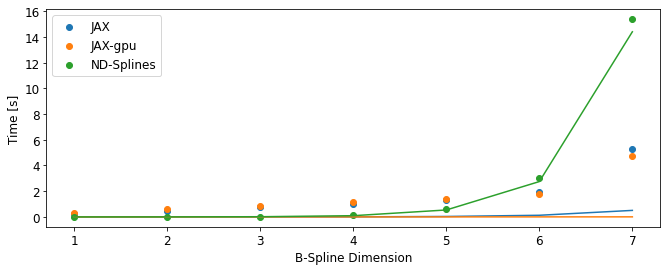

In [17]:
keys = [['JAX','JAX-gpu','ND-Splines']]#,['JAX','JAX-gpu','ND-Splines']]
times = [timings5]#, timings8]

fig, axs = plt.subplots(1,1, figsize=(11,4), sharex=True, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs#[i]
    for k in per_device:
        data = times[i][k]
        x = data[:,0]
        y_jit = data[:,1]
        # y = onp.mean(data[:,2:], 1)
        y = onp.mean(onp.sort(data[:,2:],1)[:,:-2], 1)

        ax.plot(x, y)
        # ax.set_xscale('log')
        ax.set_xlabel("B-Spline Dimension")
        ax.scatter(x, y_jit, label=k)
        # ax.set_yscale('log')
        ax.set_ylabel("Time [s]")
        ax.legend()

        
plt.show()
fig.tight_layout()
fig.savefig('dimensions-benchmark.png', dpi=fig.dpi)

## Effect of increased knot resolution

1D and 3D splines - fastest backend

### 1D

In [18]:
seed = 123
dimension = 1
# resolution = 7
degree = 3
max_time = 1
repeats=4
exponent = 6

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.Symbolic, 'cpu'),
    'JAX-gpu' : ('jax', BSplineBackend.Symbolic, 'gpu'),
    'ND-Splines' : ('ndspline',None,None),
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    for resolution in range(5,101,5):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(*x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=10, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([resolution] + t)
        
        print(f"{key}: {resolution} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break
            
timings6 = timings

JAX: 5 - [5.         0.34980521 0.04153986 0.04113142 0.04122527 0.041187
 0.04104131 0.04090885 0.04108915 0.04112451 0.04117463]
JAX: 10 - [10.          0.34160788  0.04624816  0.04327074  0.04307482  0.04341139
  0.04346957  0.04369547  0.04353897  0.04338443  0.04325446]
JAX: 15 - [15.          0.33965852  0.04352332  0.04351772  0.04346394  0.04363628
  0.05450599  0.05311764  0.04364255  0.0437593   0.04348736]
JAX: 20 - [20.          0.33911914  0.04368326  0.04380323  0.04367788  0.04392189
  0.04382885  0.04382649  0.04365062  0.04352378  0.04364731]
JAX: 25 - [25.          0.34113177  0.04585319  0.04594689  0.04582304  0.04571819
  0.04561277  0.04572065  0.04595241  0.04853055  0.04616479]
JAX: 30 - [30.          0.3476708   0.04559538  0.04590995  0.04578628  0.04615395
  0.04577606  0.04570114  0.04575668  0.04563654  0.04595423]
JAX: 35 - [35.          0.34756619  0.045998    0.04585466  0.04565908  0.0456923
  0.0461281   0.04596939  0.04613979  0.04613791  0.04612901]


### 3D

In [19]:
seed = 123
dimension = 3
# resolution = 7
degree = 3
max_time = 1
repeats=4
exponent = 6

timings = {}

settings = {
    'JAX' : ('jax', BSplineBackend.Symbolic, 'cpu'),
    'JAX-gpu' : ('jax', BSplineBackend.Symbolic, 'gpu'),
    'ND-Splines' : ('ndspline',None,None),
}

for key in settings.keys():
    timings[key] = None
    name, backend, device = settings[key]

    for resolution in range(5,31,5):
        start_time = time.time()

        size = 10 ** exponent
        res = (resolution,) * dimension
        ds = (degree,) * dimension

        c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

        sym = None
        if name == 'jax':
            s = ndSpline_unsafe(k, ds, c, backend=backend, compress=True)

            x_jax = jax.device_put(x)

            fn = jit(vmap(s), backend=device)

            sym = lambda : fn(*x_jax).block_until_ready()
        elif name == 'ndspline':
            knots = []
            for a in k:
                knots.append(onp.asarray(a))
            s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
            xs = onp.asarray(onp.stack(x,1))
            def fn():
                s(xs)
            sym = fn

        try:
            t = timeit.Timer(sym).repeat(repeat=4, number=1)
        except RuntimeError:
            break

        t_old = timings[key]

        t_new = onp.asarray([resolution] + t)
        
        print(f"{key}: {resolution} - {t_new}")

        if t_old is None:
            timings[key] = t_new
        else:
            timings[key] = onp.vstack([t_old,t_new])

        if time.time() - start_time > max_time * 60:
            break
            
timings7 = timings

JAX: 5 - [5.         1.29427321 0.34585913 0.34142685 0.34242477]
JAX: 10 - [10.          1.26042637  0.34996858  0.35158582  0.35131856]
JAX: 15 - [15.          1.27721811  0.35312691  0.35152484  0.3522116 ]
JAX: 20 - [20.          1.26150043  0.37009642  0.34596557  0.34549091]
JAX: 25 - [25.          1.26936726  0.40356481  0.35404608  0.35204508]
JAX: 30 - [30.          1.26665065  0.35138679  0.35182868  0.35307787]
JAX-gpu: 5 - [5.         0.86530251 0.01091992 0.01099584 0.01095903]
JAX-gpu: 10 - [10.          0.82273179  0.01300219  0.0129567   0.01296642]
JAX-gpu: 15 - [15.          0.83093365  0.01526136  0.0152331   0.01528787]
JAX-gpu: 20 - [2.00000000e+01 7.15238687e-01 1.65765733e-02 1.65362526e-02
 1.65704004e-02]
JAX-gpu: 25 - [2.50000000e+01 8.29895670e-01 1.79807544e-02 1.79625563e-02
 1.79640409e-02]
JAX-gpu: 30 - [3.00000000e+01 8.44312139e-01 1.81776136e-02 1.82234645e-02
 1.82650201e-02]
ND-Splines: 5 - [5.         2.38577893 2.09121691 2.05266105 2.08923424]
ND-

A: resolution 40, 10^6, deBoor backend
B: degree 3, 10^6, symbolic backend


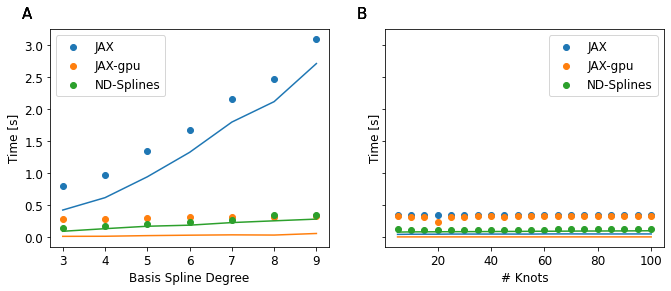

In [20]:
keys = [['JAX','JAX-gpu','ND-Splines'],['JAX','JAX-gpu','ND-Splines']]
times = [timings4, timings6]

print("A: resolution 40, 10^6, deBoor backend")
print("B: degree 3, 10^6, symbolic backend")

fig, axs = plt.subplots(1,2, figsize=(11,4), sharex=False, sharey=True)

for i, per_device in zip(range(len(keys)),keys):
    ax = axs[i]
    for k in per_device:
        data = times[i][k]
        x = data[:,0]
        y_jit = data[:,1]
        if i == 1:
            y = onp.mean(onp.sort(data[:,2:],1)[:,:-3], 1)
        else:
            y = onp.mean(data[:,2:], 1)

        ax.plot(x, y)
        # ax.set_xscale('log')
        if i == 0:
            ax.set_xlabel("Basis Spline Degree")
        else:
            ax.set_xlabel("# Knots")
        ax.scatter(x, y_jit, label=k)
        # ax.set_yscale('log')
        ax.set_ylabel("Time [s]")
        ax.legend()
        ax.text(-0.1, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, 
            size=15)


plt.show()
fig.tight_layout()
fig.savefig('Degree-resolution-benchmark.png', dpi=fig.dpi)

# Profiling

In [6]:
seed = 123
size = 100
dimension = 1
resolution = 150
degree = 3

res = (resolution,) * dimension
ds = (degree,) * dimension

c, k, x = random_spline(res, sample=size, seed=seed)
s = ndSpline_unsafe(c, k, ds, backend=BSplineBackend.Symbolic, naive_search=False)

x_jax = jax.device_put(x)
fn = jit(vmap(s))

with jax.profiler.trace("/tmp/jax-trace1", create_perfetto_link=False):
    fn(x_jax).block_until_ready()
    fn(x_jax).block_until_ready()